In [1]:
import twitter
import configparser
import numpy as np

"""
各位所有のtwitter api keyを読み込んで使ってください

CONSUMER_KEY = 
CONSUMER_SECRET = 
ACCESS_TOKEN_KEY = 
ACCESS_TOKEN_SECRET = 

"""

api = twitter.Api(consumer_key=CONSUMER_KEY,
                  consumer_secret=CONSUMER_SECRET,
                  access_token_key=ACCESS_TOKEN_KEY,
                  access_token_secret=ACCESS_TOKEN_SECRET)
liquidated_list=[]
last_id=0

for i in range(3):
    if i==0:
        tweets = api.GetUserTimeline(screen_name="BitmexRekt",count=200)
    else:
        tweets = api.GetUserTimeline(screen_name="BitmexRekt",max_id=last_id-1,count=200)

    for tweet in tweets:
        word_list=tweet.text.split()
        if 'XBTUSD:' in word_list:
            if word_list[1]=='long':
                amount=(-1)*int(word_list[5].replace(",",""))
                at_price=float(word_list[7])
                liquidated_list.append([tweet.created_at,amount,at_price])
            elif word_list[1]=='short':
                amount=int(word_list[5].replace(",",""))
                at_price=float(word_list[7])
                liquidated_list.append([tweet.created_at,amount,at_price])
        last_id=tweet.id
            
#以下は word_list の format
#Liquidated short on XBTUSD: Buy 11,305 @ 3823.5

In [2]:
import datetime

#この時点で後の便宜上秒を切り捨てている

def make_datetime(liqlist_time):
    parts=liqlist_time.split()
    hms=parts[3].split(":")
    month_dec={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    return(datetime.datetime(year=int(parts[5]),month=month_dec[parts[1]],day=int(parts[2]),hour=int(hms[0]),minute=int(hms[1]),second=0,tzinfo=datetime.timezone(datetime.timedelta(0))))

In [3]:
#UNIX timeにそろえる

for i in range(len(liquidated_list)):
    liquidated_list[i][0]=(make_datetime(liquidated_list[i][0])).timestamp()

In [4]:
#各取引所の価格情報を拾ってくる
#0,1,2,3,4 : time,open,high,low,close

import get_ohlcv
prices=np.array(get_ohlcv.get_chart('mex',1))
bf_prices=np.array(get_ohlcv.get_chart('bffx',1))

In [5]:
#shortのロスカットとlongのロスカットに分類

liquidated_short_list=[]
liquidated_long_list=[]
for i in range(len(liquidated_list)):
    if liquidated_list[i][1]<0:
        liquidated_long_list.append(liquidated_list[i])
    else:
        liquidated_short_list.append(liquidated_list[i])
liquidated_list=np.array(liquidated_list)
liquidated_short_list=np.array(liquidated_short_list)
liquidated_long_list=np.array(liquidated_long_list)

In [6]:
#twitterデータは時間が降順になっている
#価格データは時間が昇順になっている
#たいていの場合ロスカットデータのほうが古くまでとれる(価格データは500個まで)ので、一番古い価格データの時刻以前のロスカットデータを消す

time_begin=min(prices[0])
k=0
l=0
for i in range(len(liquidated_long_list[:,0])):
    if liquidated_long_list[i][0]>=time_begin:
        k+=1
for j in range(len(liquidated_short_list[:,0])):
    if liquidated_short_list[j][0]>=time_begin:
        l+=1

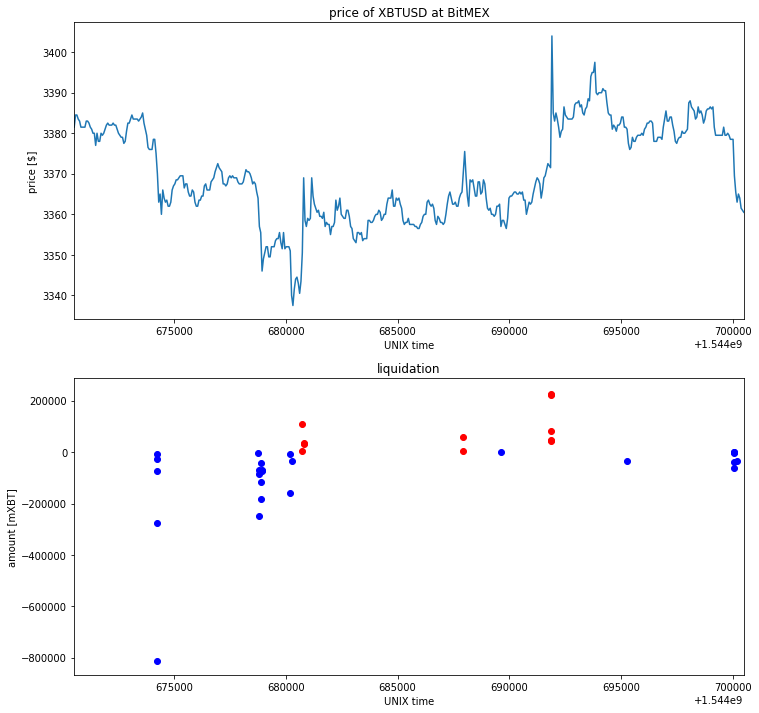

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.2)

plt.subplot(2,1,1)
plt.title('price of XBTUSD at BitMEX')
plt.xlabel('UNIX time')
plt.ylabel('price [$]')
plt.xlim([min(prices[0]),max(prices[0])])
plt.plot(prices[0],prices[4])

plt.subplot(2,1,2)
plt.title('liquidation')
plt.xlabel('UNIX time')
plt.ylabel('amount [mXBT]')
plt.xlim([min(prices[0]),max(prices[0])])
plt.scatter(liquidated_long_list[:k,0],liquidated_long_list[:k,1],color='b')
plt.scatter(liquidated_short_list[:l,0],liquidated_short_list[:l,1],color='r')

plt.show()

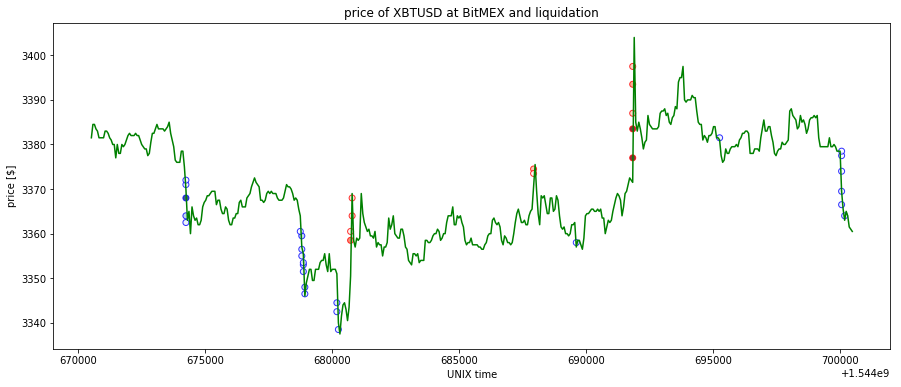

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,6))

plt.title('price of XBTUSD at BitMEX and liquidation')
plt.xlabel('UNIX time')
plt.ylabel('price [$]')

plt.plot(prices[0],prices[4],color='g')

plt.scatter(liquidated_long_list[:k,0],liquidated_long_list[:k,2],c=abs(liquidated_long_list[:k,1]),cmap='Blues',alpha=0.8,edgecolors="b")
plt.scatter(liquidated_short_list[:l,0],liquidated_short_list[:l,2],c=liquidated_short_list[:l,1],cmap='Reds',alpha=0.8,edgecolors="red")

plt.show()

total profit:85.0[$] average:5.666666666666667[$] entry times:15
long profit:45.5[$] average:11.375[$] entry times:4
short profit:39.5[$] average:3.590909090909091[$] entry times:11
net plus:102.0[$] net minus:-17.0[$]
profit factor:6.0
max drawdown:-10.5[$]
win percentage:73.33333333333333[%]


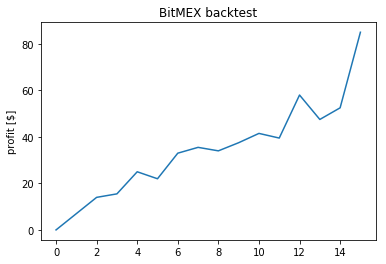

In [9]:
#BitMEXのバックテストをする
profit=0
long_profit=0
short_profit=0

profit_history=[0]
pure_profit=0
pure_loss=0
win_times=0
lose_times=0

buy_time_index=[]
sell_time_index=[]

for i in range(k): #ロスカットリストの各要素について、ロスカット発生時刻(の秒を切り捨て)と同時刻の価格データのindexを取得
    sell_time_index.append(np.where(prices[0]==liquidated_long_list[i][0])[0][-1])
sell_time_index=sorted(list(set(sell_time_index)))
for j in range(l):
    buy_time_index.append(np.where(prices[0]==liquidated_short_list[j][0])[0][-1])
buy_time_index=sorted(list(set(buy_time_index)))

long_entry_times=len(buy_time_index)
short_entry_times=len(sell_time_index)

for i in range(len(sell_time_index)): #longのロスカットが起きた分足の終値でshort entry 1分後の終値で決済
    delta=prices[4][sell_time_index[i]]-prices[4][sell_time_index[i]+1]
    profit+=delta
    profit_history.append(profit)
    short_profit+=delta
    if delta>=0:
        pure_profit+=delta
        win_times+=1
    else:
        pure_loss+=delta
        lose_times+=1
        
for j in range(len(buy_time_index)): #shortのロスカットが起きた分足の終値でlong entry 1分後の終値で決済
    delta=prices[4][buy_time_index[j]+1]-prices[4][buy_time_index[j]]
    profit+=delta
    profit_history.append(profit)
    long_profit+=delta
    if delta>=0:
        pure_profit+=delta
        win_times+=1
    else:
        pure_loss+=delta
        lose_times+=1
        
profit_factor=abs(pure_profit/pure_loss) if pure_loss!=0 else 'undefined'

drawdown=[]
temp_drawdown=0
for i in range(1,len(profit_history)):
    if profit_history[i]-profit_history[i-1]<0:
        temp_drawdown+=profit_history[i]-profit_history[i-1]
    else:
        drawdown.append(temp_drawdown)
        temp_drawdown=0
drawdown=min(drawdown)

win_percentage=win_times/(win_times+lose_times)*100
    
print("total profit:{0}[$] average:{1}[$] entry times:{2}\nlong profit:{3}[$] average:{4}[$] entry times:{5}\nshort profit:{6}[$] average:{7}[$] entry times:{8}\nnet plus:{9}[$] net minus:{10}[$]\nprofit factor:{11}\nmax drawdown:{12}[$]\nwin percentage:{13}[%]".format(
    profit,profit/(long_entry_times+short_entry_times),long_entry_times+short_entry_times,long_profit,long_profit/long_entry_times,long_entry_times,short_profit,short_profit/short_entry_times,short_entry_times,pure_profit,pure_loss,profit_factor,drawdown,win_percentage))

plt.plot(profit_history)
plt.title('BitMEX backtest')
plt.ylabel('profit [$]')
plt.show()

total profit:7779.0[yen] average:518.6[yen] entry times:15
long profit:2619.0[yen] average:654.75[yen] entry times:4
short profit:5160.0[yen] average:469.09090909090907[yen] entry times:11
net plus:8443.0[yen] net minus:-664.0[yen]
profit factor:12.715361445783133
max drawdown:-341.0[yen]
win percentage:73.33333333333333[%]


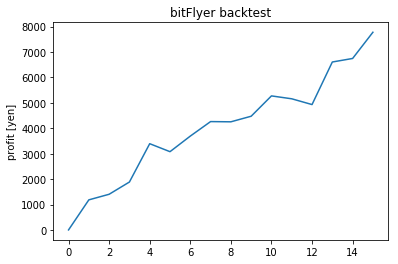

In [10]:
#bitFlyerのバックテストをする BitMEXのロスカットをシグナルにbitFlyerで売買したらどうなるか？
profit=0
long_profit=0
short_profit=0

profit_history=[0]
pure_profit=0
pure_loss=0

win_times=0
lose_times=0

for i in range(len(sell_time_index)): #longのロスカットが起きた分足の終値でshort entry 1分後に決済
    delta=bf_prices[4][sell_time_index[i]]-bf_prices[4][sell_time_index[i]+1]
    profit+=delta
    profit_history.append(profit)
    short_profit+=delta
    if delta>0:
        pure_profit+=delta
        win_times+=1
    else:
        pure_loss+=delta
        lose_times+=1
for j in range(len(buy_time_index)): #shortのロスカットが起きた分足の終値でlong entry 1分後に決済
    delta=bf_prices[4][buy_time_index[j]+1]-bf_prices[4][buy_time_index[j]]
    profit+=delta
    profit_history.append(profit)
    long_profit+=delta
    if delta>0:
        pure_profit+=delta
        win_times+=1
    else:
        pure_loss+=delta
        lose_times+=1
        
profit_factor=abs(pure_profit/pure_loss) if pure_loss!=0 else 'undefined'

drawdown=[]
temp_drawdown=0
for i in range(1,len(profit_history)):
    if profit_history[i]-profit_history[i-1]<0:
        temp_drawdown+=profit_history[i]-profit_history[i-1]
    else:
        drawdown.append(temp_drawdown)
        temp_drawdown=0
drawdown=min(drawdown)

win_percentage=win_times/(win_times+lose_times)*100
        
print("total profit:{0}[yen] average:{1}[yen] entry times:{2}\nlong profit:{3}[yen] average:{4}[yen] entry times:{5}\nshort profit:{6}[yen] average:{7}[yen] entry times:{8}\nnet plus:{9}[yen] net minus:{10}[yen]\nprofit factor:{11}\nmax drawdown:{12}[yen]\nwin percentage:{13}[%]".format(
    profit,profit/(long_entry_times+short_entry_times),long_entry_times+short_entry_times,long_profit,long_profit/long_entry_times,long_entry_times,short_profit,short_profit/short_entry_times,short_entry_times,pure_profit,pure_loss,profit_factor,drawdown,win_percentage))

plt.plot(profit_history)
plt.title('bitFlyer backtest')
plt.ylabel('profit [yen]')
plt.show()